### Introduction/Business Problem

Car accidents have a huge social, economic and environmental impact to our world. Approximately 54 million people sustained injuries from car accidents each year and more than 1.4 millions resulted to deaths. Road traffic injuries are the leading cause of death for children and young adults aged 5-29 years. The road traffic crashes costs more than 3% of GDP.

It would be hugly important to predict the severity of a car accident and warn the drivers,in advance and on time, in order to drive more savely or even to adjust their journey.

Thus, the aim of this project is to apply quantitative methods and create a model that predicts the severity of a car accident based on weather and road conditions, traffic jam etc.

The dataset are from Kaggle and contains details of traffic accidents in pennsylvania State of United States for the years of 2016 - 2020

### Let's import our Data and Libraries

In [1]:
import pandas as pd
df = pd.read_csv('last.csv')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

### Let's have a quick look at our data

In [3]:
df.head(3)

,Unnamed: 0,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,197865,A-197867,MapQuest,201.0,3,2016-12-26 14:00:12,2016-12-26 14:45:00,41.338398,-74.837120,NaN,NaN,0.01,Accident on I-84 Eastbound at Exit 46 US-6 Gra...,NaN,I-84 E,R,Milford,Pike,PA,18337,US,US/Eastern,KFWN,2016-12-26 13:53:00,28.9,25.2,85.0,30.54,3.0,East,3.5,0.01,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1,208994,A-208996,MapQuest,201.0,2,2016-09-21 09:56:46,2016-09-21 10:41:24,41.408066,-74.914040,NaN,NaN,0.00,Accident on Twin Lakes Rd near Don Dr.,655.0,Twin Lakes Rd,L,Shohola,Pike,PA,18458-4247,US,US/Eastern,KMSV,2016-09-21 09:55:00,66.2,NaN,60.0,30.27,10.0,North,6.9,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,214862,A-214864,MapQuest,201.0,2,2016-08-24 11:03:17,2016-08-24 11:48:17,41.324230,-74.806488,NaN,NaN,0.00,Accident on US-6 Harford St both ways at 6th St.,265.0,W Harford St,R,Milford,Pike,PA,18337-1104,US,US/Eastern,KFWN,2016-08-24 10:53:00,75.9,NaN,69.0,30.28,10.0,SSE,4.6,NaN,Clear,False,False,True,False,False,False,False,False,False,True,False,False,False,Day,Day,Day,Day


### Edit date and time columns

In [4]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%B')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))

### Visualize some key statistics

<AxesSubplot:title={'center':'Station'}>

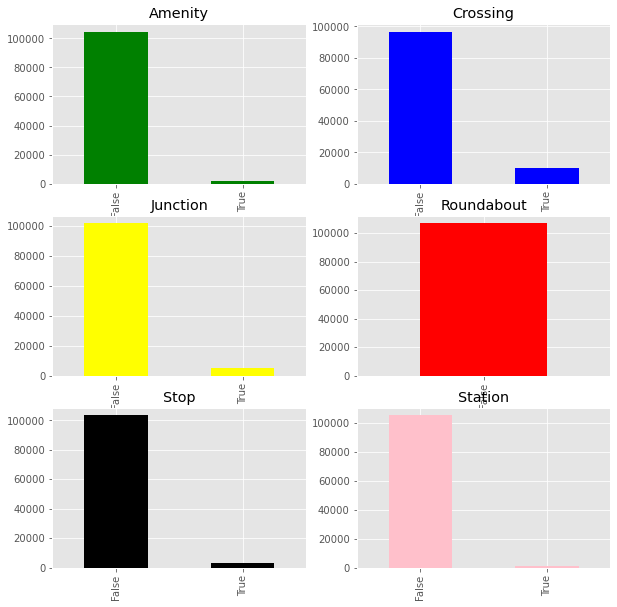

In [5]:
### Plot some boolean values
fig = plt.figure(figsize=(10,10)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (0, 0))
df['Amenity'].value_counts().plot(kind='bar', color ='green',
                                     title='Amenity')
plt.subplot2grid(fig_dims, (0, 1))
df['Crossing'].value_counts().plot(kind='bar',color = 'blue',
                                     title='Crossing')
plt.subplot2grid(fig_dims, (1, 0))
df['Junction'].value_counts().plot(kind='bar',color = 'yellow',
                                     title='Junction')
plt.subplot2grid(fig_dims, (1, 1))
df['Roundabout'].value_counts().plot(kind='bar',color = 'red',
                                     title='Roundabout')        
plt.subplot2grid(fig_dims, (2, 0))
df['Stop'].value_counts().plot(kind='bar',color = 'black',
                                     title='Stop') 
plt.subplot2grid(fig_dims, (2, 1))
df['Station'].value_counts().plot(kind='bar',color = 'pink',
                                     title='Station') 

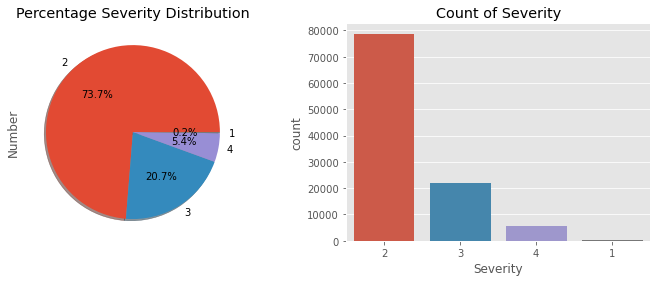

In [6]:
### The severity distribution
f,ax=plt.subplots(1,2,figsize=(12,4))
df['Severity'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Percentage Severity Distribution')
ax[0].set_ylabel('Number')
sns.countplot('Severity',data=df,ax=ax[1],order=df['Severity'].value_counts().index)
ax[1].set_title('Count of Severity')
plt.show()

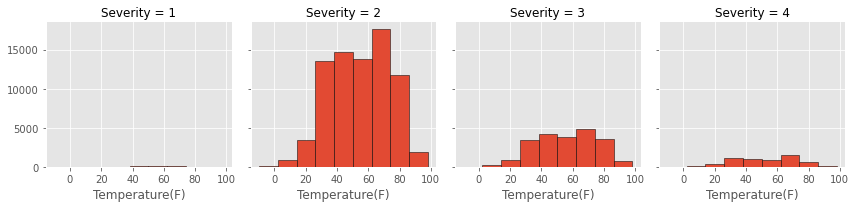

In [7]:
### Severity based on Temperature

bins = np.linspace(df['Temperature(F)'].min(), df['Temperature(F)'].max(), 10)
g = sns.FacetGrid(df, col='Severity', palette="Set2", col_wrap=4)
g.map(plt.hist, 'Temperature(F)', bins=bins, ec="k")

plt.show()

<AxesSubplot:title={'center':'Astronomical_Twilight '}>

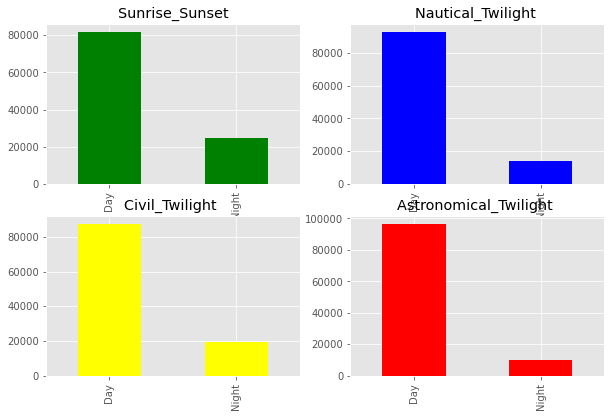

In [8]:
fig = plt.figure(figsize=(10,10)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (0, 0))
df['Sunrise_Sunset'].value_counts().plot(kind='bar', color ='green',
                                     title='Sunrise_Sunset')
plt.subplot2grid(fig_dims, (0, 1))
df['Nautical_Twilight'].value_counts().plot(kind='bar',color = 'blue',
                                     title='Nautical_Twilight ')
plt.subplot2grid(fig_dims, (1, 0))
df['Civil_Twilight'].value_counts().plot(kind='bar',color = 'yellow',
                                     title='Civil_Twilight ')
plt.subplot2grid(fig_dims, (1, 1))
df['Astronomical_Twilight'].value_counts().plot(kind='bar',color = 'red',
                                     title='Astronomical_Twilight ')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'By Month'}, xlabel='Month'>

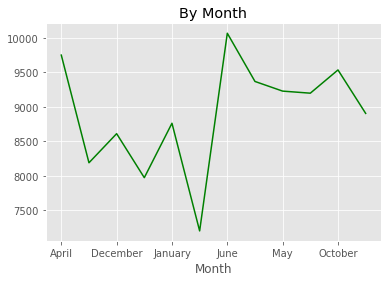

In [9]:
df.groupby("Month").size().plot(kind="line",color = 'green', title= 'By Month')

<AxesSubplot:title={'center':'By Weekday'}, xlabel='Weekday'>

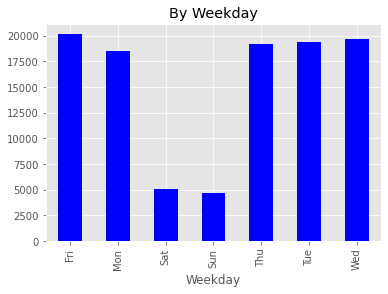

In [10]:
df.groupby("Weekday").size().plot(kind="bar",color = 'blue', title = 'By Weekday')

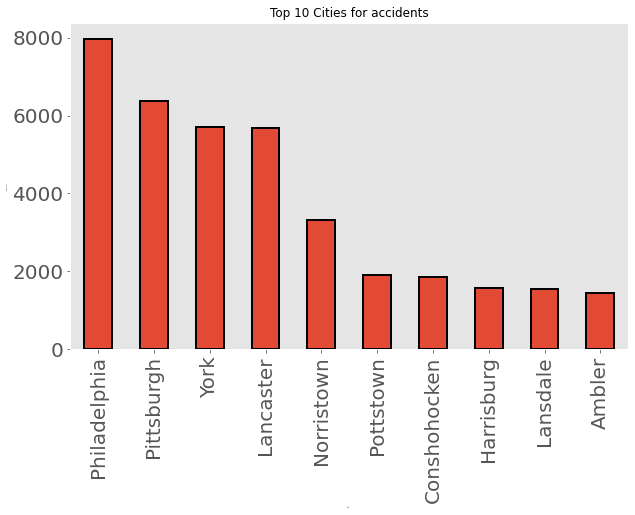

In [11]:
### Top 10 cities for accidents 

fig, ax=plt.subplots(figsize=(10,6))
df['City'].value_counts().sort_values(ascending=False).head(10).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2)
plt.xlabel('City',fontsize=2)
plt.ylabel('Number',fontsize=2)
ax.tick_params(labelsize=20)
plt.title('Top 10 Cities for accidents',fontsize=12)
plt.grid()
plt.ioff()

#### Clean some rows and columns

In [12]:
# Remove outliers and negative values
df[td][df[td]<=0]
neg_outliers=df[td]<=0
df[neg_outliers] = np.nan

df.dropna(subset=[td],axis=0,inplace=True)

n=3
median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n
df[outliers] = np.nan
df[td].fillna(median, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106787 entries, 0 to 106786
Data columns (total 56 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             106766 non-null  float64       
 1   ID                     106766 non-null  object        
 2   Source                 106766 non-null  object        
 3   TMC                    86366 non-null   float64       
 4   Severity               106766 non-null  float64       
 5   Start_Time             106766 non-null  datetime64[ns]
 6   End_Time               106766 non-null  datetime64[ns]
 7   Start_Lat              106766 non-null  float64       
 8   Start_Lng              106766 non-null  float64       
 9   End_Lat                20400 non-null   float64       
 10  End_Lng                20400 non-null   float64       
 11  Distance(mi)           106766 non-null  float64       
 12  Description            106766 non-null  obje

#### Drop some columns

In [13]:
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']

In [14]:
df=df[feature_lst].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106787 entries, 0 to 106786
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Source              106766 non-null  object 
 1   TMC                 86366 non-null   float64
 2   Severity            106766 non-null  float64
 3   Start_Lng           106766 non-null  float64
 4   Start_Lat           106766 non-null  float64
 5   Distance(mi)        106766 non-null  float64
 6   Side                106766 non-null  object 
 7   City                106766 non-null  object 
 8   County              106766 non-null  object 
 9   State               106766 non-null  object 
 10  Timezone            106766 non-null  object 
 11  Temperature(F)      105434 non-null  float64
 12  Humidity(%)         105259 non-null  float64
 13  Pressure(in)        105804 non-null  float64
 14  Visibility(mi)      105218 non-null  float64
 15  Weather_Condition   105338 non-nul

In [15]:
df.dropna(subset=df.columns[df.isnull().mean()!=0], how='any', axis=0, inplace=True)
df.shape

(84573, 33)

#### Transform the categorigal values

In [16]:
df_dummy = pd.get_dummies(df,drop_first=True)
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84573 entries, 0 to 86365
Columns: 1219 entries, TMC to Weekday_Wed
dtypes: float64(24), uint8(1195)
memory usage: 112.5 MB


### Predict the severity of an accident by different Machine Learning methods

In [17]:
# Create training and testing data 

df=df_dummy
target='Severity'

y = df[target]
X = df.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [18]:
# Algorithms that will be used 
algo_lst=['Logistic Regression','Decision Trees',' K-Nearest Neighbors']
accuracy_lst=[]

#### Logistic regression

In [19]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

acc=accuracy_score(y_test, y_pred)
accuracy_lst.append(acc)

print('The accuracy_score of logistics regression is: {:.3f}.'.format(acc))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The accuracy_score of logistics regression is: 0.900.


#### Decision tree

In [20]:
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)
dt_entropy.fit(X_train, y_train)
y_pred= dt_entropy.predict(X_test)

accuracy_entropy = accuracy_score(y_test, y_pred)

print('The accuracy_score of Decision Tree entropy is: {:.3f}.'.format(accuracy_entropy))

dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)
dt_gini.fit(X_train, y_train)
y_pred= dt_gini.predict(X_test)

accuracy_gini = accuracy_score(y_test, y_pred)

acc=accuracy_gini
accuracy_lst.append(acc)

print('The accuracy_score of Decision Tree gini is: {:.3f}.'.format(accuracy_gini))

The accuracy_score of Decision Tree entropy is: 0.869.
The accuracy_score of Decision Tree gini is: 0.874.


#### K-Nearest Neighbors 

In [21]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

acc=accuracy_score(y_test, y_pred)
accuracy_lst.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

[K-Nearest Neighbors (KNN)] knn.score: 0.812.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.812.
